In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from miscellaneous.loader import load_image
from miscellaneous.propagator import angular_spectrum_band_limited
from miscellaneous.tie import FFTSolver2D

In [21]:
file = '../../generation/image/BMSTU 1024x1024.png'
phase = load_image(file) + 0.2

In [22]:
i_amplitude = 0.5
intensity = i_amplitude * np.ones(phase.shape)

mean = 0.0
standard_deviation = 0.001
noise = np.random.normal(mean, standard_deviation, size=intensity.shape)
intensity += noise
complex_field_back_propagation = np.sqrt(intensity) * np.exp(1j * phase)

noise = np.random.normal(mean, standard_deviation, size=intensity.shape)
intensity += noise
complex_field_forward_propagation = np.sqrt(intensity) * np.exp(1j * phase)

In [23]:
start=0.000010  # 10 mkm
stop=0.001  # 1000 mkm
step=0.000010  # 10 mkm

px_size = 0.000005  # 5 mkm
wavelength = 0.000000555  # 555 nm

distances = np.arange(start, stop + step, step)
forward_propagated_fields = []
for distance in distances:
    complex_field = np.copy(complex_field_forward_propagation)
    forward_propagated_fields.append(angular_spectrum_band_limited(complex_field, distance, wavelength, px_size))

In [24]:
start=-0.000010  # -10 mkm
stop=-0.001  # -2500 mkm
step=-0.000010  # -10 mkm

distances = np.arange(start, stop + step, step)
back_propagated_fields = []
for distance in distances:
    complex_field = np.copy(complex_field_back_propagation)
    back_propagated_fields.append(angular_spectrum_band_limited(complex_field, distance, wavelength, px_size))

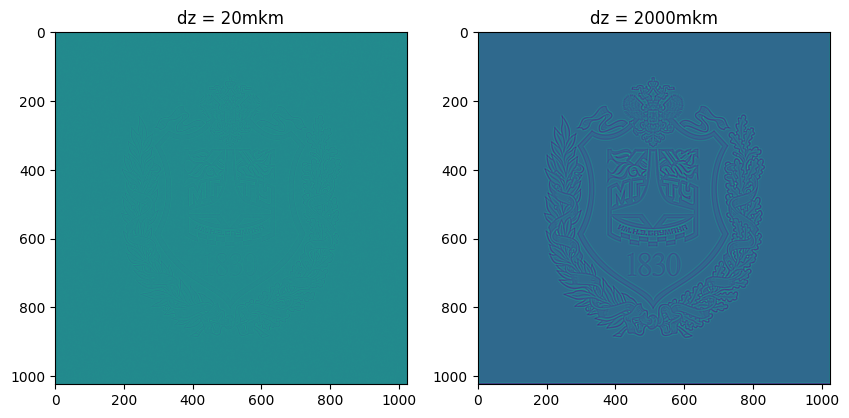

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8), dpi=100)

ax1.imshow(np.abs(forward_propagated_fields[0])**2)
ax1.set_title('dz = 20mkm')
ax2.imshow(np.abs(forward_propagated_fields[-1])**2)
ax2.set_title('dz = 2000mkm')

plt.show()

In [27]:
start=0.000010  # 10 mkm
stop=0.001  # 1000 mkm
step=0.000010  # 10 mkm

distances = np.arange(start, stop + step, step)
retrieved_phases = {}
for dz, i in zip(distances, range(len(distances))):
    intensities = [np.abs(field) ** 2 for field in [forward_propagated_fields[i], back_propagated_fields[i]]]

    dz = 2 * dz
    dz = - dz
    threshold = 0.1

    solver = FFTSolver2D(intensities, dz, wavelength, px_size)
    retrieved_phases[-dz] = solver.solve(threshold)

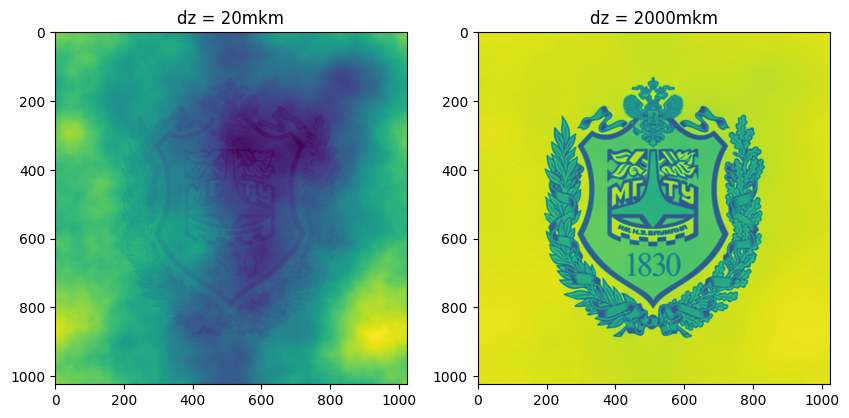

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8), dpi=100)

ax1.imshow(retrieved_phases[0.00002])
ax1.set_title('dz = 20mkm')
ax2.imshow(retrieved_phases[0.002])
ax2.set_title('dz = 2000mkm')

plt.show()

In [33]:
def find_power(data:np.ndarray):
    def calculate_row_power(a):
        th = 0.0001
        row_power = 0
        for i in range(a.size - 1):
            if (a[i+1] - a[i]) ** 2 >= th: row_power += a[i+1]**2
        return row_power

    return np.sum(np.apply_along_axis(calculate_row_power, 0, data)) + \
           np.sum(np.apply_along_axis(calculate_row_power, 1, data))

gradient_powers = {}

for dz, phase in retrieved_phases.items():
    gradient_powers[dz] = find_power(phase)

In [34]:
from scipy.ndimage import convolve

def laplace_matrix(array, inward=True):
    if inward:
        kernel = np.array([
            [0, +1, 0],
            [1, -4, 1],
            [0, +1, 0],
        ])
    else:
        kernel = np.array([
            [0,  -1, 0],
            [-1, +4, -1],
            [0,  -1, 0],
        ])

    convolved = np.abs(convolve(array, kernel))

    result = np.abs(convolved)
    return result

convolved_matrixes = {}
for dz, phase in retrieved_phases.items():
    convolved_matrixes[dz] = laplace_matrix(phase)

def find_power(data: np.ndarray) -> int:
    return np.sum(data)

laplace_powers = {}

for dz, phase in convolved_matrixes.items():
    laplace_powers[dz] = find_power(phase)

In [35]:
def prewitt_matrix(array):
    kernelx = np.array([
        [+1, 0, -1],
        [+1, 0, -1],
        [+1, 0, -1],
    ])
    kernely = np.array([
        [+1, +1, +1],
        [ 0,  0,  0],
        [-1, -1, -1],
    ])

    x = np.abs(convolve(array, kernelx))
    y = np.abs(convolve(array, kernely))

    result = np.sqrt(x ** 2 + y ** 2)
    return result

convolved_matrixes = {}
for dz, phase in retrieved_phases.items():
    convolved_matrixes[dz] = prewitt_matrix(phase)

def find_power(data: np.ndarray) -> int:
    return np.sum(data)

prewitt_powers = {}

for dz, phase in convolved_matrixes.items():
    prewitt_powers[dz] = find_power(phase)

In [36]:
def roberts_matrix(array):
    kernelx = np.array([[-1, 0], [0, 1]])
    kernely = np.array([[0, -1], [1, 0]])

    x = np.abs(convolve(array, kernelx))
    y = np.abs(convolve(array, kernely))

    result = np.sqrt(x ** 2 + y ** 2)
    return result

convolved_matrixes = {}
for dz, phase in retrieved_phases.items():
    convolved_matrixes[dz] = roberts_matrix(phase)

def find_power(data: np.ndarray) -> int:
    return np.sum(data)

roberts_powers = {}

for dz, phase in convolved_matrixes.items():
    roberts_powers[dz] = find_power(phase)

In [37]:
def sobel_matrix(array):
    kernelx = np.array([
        [+1, 0, -1],
        [+2, 0, -2],
        [+1, 0, -1],
    ])
    kernely = np.array([
        [+1, +2, +1],
        [ 0,  0,  0],
        [-1, -2, -1],
    ])

    x = np.abs(convolve(array, kernelx))
    y = np.abs(convolve(array, kernely))

    result = np.sqrt(x ** 2 + y ** 2)
    return result

convolved_matrixes = {}
for dz, phase in retrieved_phases.items():
    convolved_matrixes[dz] = sobel_matrix(phase)

def find_power(data: np.ndarray) -> int:
    return np.sum(data)

sobel_powers = {}

for dz, phase in convolved_matrixes.items():
    sobel_powers[dz] = find_power(phase)

In [38]:
gradient_powers.pop(0.00002)
gradient_powers.pop(0.00004)
gradient_powers.pop(6.000000000000001e-05)
laplace_powers.pop(0.00002)
laplace_powers.pop(0.00004)
laplace_powers.pop(6.000000000000001e-05)
prewitt_powers.pop(0.00002)
prewitt_powers.pop(0.00004)
prewitt_powers.pop(6.000000000000001e-05)
sobel_powers.pop(0.00002)
sobel_powers.pop(0.00004)
sobel_powers.pop(6.000000000000001e-05)
roberts_powers.pop(0.00002)
roberts_powers.pop(0.00004)
roberts_powers.pop(6.000000000000001e-05)

50767.32486548128

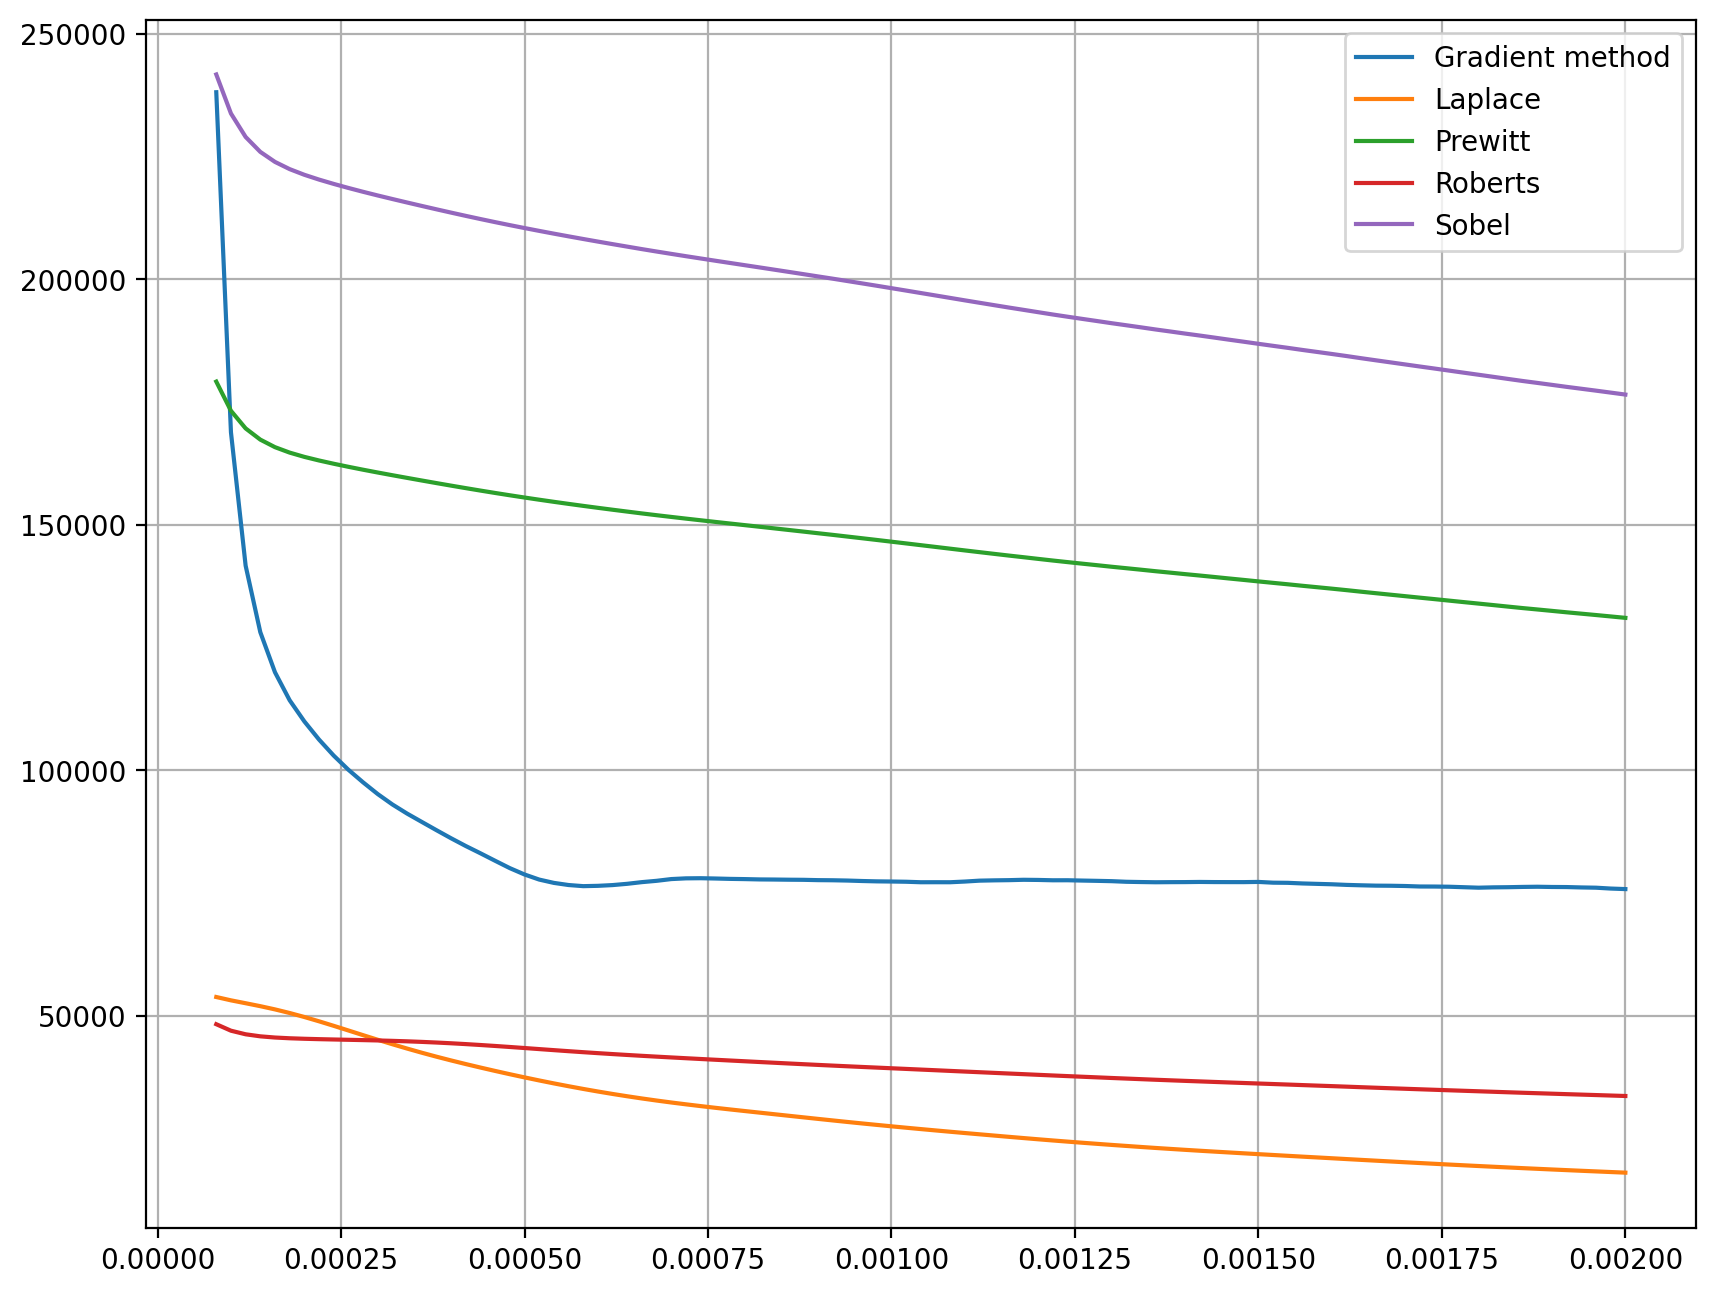

In [39]:
figure(figsize=(10, 8), dpi=200)
plt.plot(gradient_powers.keys(), gradient_powers.values(), label='Gradient method')
plt.plot(laplace_powers.keys(), laplace_powers.values(), label='Laplace')
plt.plot(prewitt_powers.keys(), prewitt_powers.values(), label='Prewitt')
plt.plot(roberts_powers.keys(), roberts_powers.values(), label='Roberts')
plt.plot(sobel_powers.keys(), sobel_powers.values(), label='Sobel')
plt.grid()
plt.legend()
plt.show()